# Summary Notebook

## Assumptions
1. consider price as per week if it do not mention and less than 5000 dollars
2. if the description does not contain furnished, consider it as not furnished, 1 represents furnished, 0 represents not furnished

In [51]:
import numpy as np
import pandas as pd
import folium
import geopandas as gpd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [52]:
df = pd.read_csv("../data/curated/predict_data.csv")
df.head()

,url,postcode,longitude,latitude,price,bed,bath,parking,cbd_dist,school_counts,furnished,2022 no.,2023 no.,2024 no.,2025 no.
0,https://www.domain.com.au/9-21-rockley-road-so...,3141,144.999757,-37.837338,400.0,1,1,1.0,5.9614,6.0,0,6515.0,6508.0,6512.0,6520.0
1,https://www.domain.com.au/35-233-canterbury-ro...,3182,144.976195,-37.859150,360.0,1,1,1.0,4.1882,5.0,0,16152.0,16303.0,16522.0,16692.0
2,https://www.domain.com.au/2-31-howitt-street-s...,3141,145.002817,-37.846776,320.0,1,1,0.0,6.9114,6.0,0,6515.0,6508.0,6512.0,6520.0
3,https://www.domain.com.au/2-17-railway-parade-...,3163,145.069344,-37.891722,360.0,1,1,1.0,14.3864,5.0,0,14114.0,14380.0,14662.0,14942.0
4,https://www.domain.com.au/2-16-vale-st-st-kild...,3182,144.983362,-37.866152,320.0,1,1,1.0,5.8505,5.0,0,16152.0,16303.0,16522.0,16692.0


## Features we used: 
bed, bath, parking, cbd_dist, school_counts, furnished, population (only used in prediction)

In [53]:
df_d = df.drop(['url','longitude','latitude','postcode','parking','bath','2022 no.', 
                '2023 no.','2024 no.','2025 no.'], axis = 1)
df_d.head()

,price,bed,cbd_dist,school_counts,furnished
0,400.0,1,5.9614,6.0,0
1,360.0,1,4.1882,5.0,0
2,320.0,1,6.9114,6.0,0
3,360.0,1,14.3864,5.0,0
4,320.0,1,5.8505,5.0,0


<AxesSubplot:>

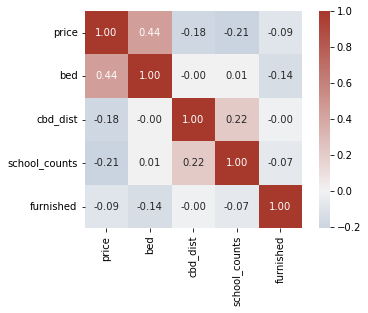

In [54]:
matrix = df_d.corr()
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
sns.heatmap(matrix,center=0, annot=True,fmt='.2f', square=True, cmap=cmap)

## Most important features
Most important internal feature: Bed; Most important external feature: the number of schools; 

In [55]:
# select columns
df = df.iloc[:, [1,4,5,6,7,8,9,10,11,12,13,14]]
df.head()

,postcode,price,bed,bath,parking,cbd_dist,school_counts,furnished,2022 no.,2023 no.,2024 no.,2025 no.
0,3141,400.0,1,1,1.0,5.9614,6.0,0,6515.0,6508.0,6512.0,6520.0
1,3182,360.0,1,1,1.0,4.1882,5.0,0,16152.0,16303.0,16522.0,16692.0
2,3141,320.0,1,1,0.0,6.9114,6.0,0,6515.0,6508.0,6512.0,6520.0
3,3163,360.0,1,1,1.0,14.3864,5.0,0,14114.0,14380.0,14662.0,14942.0
4,3182,320.0,1,1,1.0,5.8505,5.0,0,16152.0,16303.0,16522.0,16692.0


In [56]:
# deal with categorical variables
dummies = pd.get_dummies(df.furnished, prefix = ['f'])
df = pd.concat([df, dummies],axis = 1)
del df['furnished']

## calculate the population change every year

In [57]:
# calculate population change each year
df['pop23-22'] = df['2023 no.'] - df['2022 no.']
df['pop24-23'] = df['2024 no.'] - df['2023 no.']
df['pop25-24'] = df['2025 no.'] - df['2024 no.']
df = df.drop(columns = ['2022 no.', '2023 no.', '2024 no.', '2025 no.'])
df.head()

,postcode,price,bed,bath,parking,cbd_dist,school_counts,['f']_0,['f']_1,pop23-22,pop24-23,pop25-24
0,3141,400.0,1,1,1.0,5.9614,6.0,1,0,-7.0,4.0,8.0
1,3182,360.0,1,1,1.0,4.1882,5.0,1,0,151.0,219.0,170.0
2,3141,320.0,1,1,0.0,6.9114,6.0,1,0,-7.0,4.0,8.0
3,3163,360.0,1,1,1.0,14.3864,5.0,1,0,266.0,282.0,280.0
4,3182,320.0,1,1,1.0,5.8505,5.0,1,0,151.0,219.0,170.0


## Start to fit linear regression model

In [58]:
y = np.array(df['price'])
x = df.drop(columns = ['postcode', 'price', 'pop24-23', 'pop25-24'], axis = 1)
x_list = list(x.columns)
x = np.array(x)
x

array([[  1.,   1.,   1., ...,   1.,   0.,  -7.],
       [  1.,   1.,   1., ...,   1.,   0., 151.],
       [  1.,   1.,   0., ...,   1.,   0.,  -7.],
       ...,
       [  2.,   1.,   0., ...,   1.,   0., 598.],
       [  2.,   2.,   1., ...,   1.,   0., 221.],
       [  2.,   1.,   1., ...,   1.,   0.,  50.]])

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.28, random_state = 42)

In [60]:
# fit a linear regression model
model = LinearRegression().fit(x_train, y_train)

In [61]:
y_pred = model.predict(x)

In [62]:
df['price_2023'] = y_pred
df.head()

,postcode,price,bed,bath,parking,cbd_dist,school_counts,['f']_0,['f']_1,pop23-22,pop24-23,pop25-24,price_2023
0,3141,400.0,1,1,1.0,5.9614,6.0,1,0,-7.0,4.0,8.0,366.621240
1,3182,360.0,1,1,1.0,4.1882,5.0,1,0,151.0,219.0,170.0,375.578976
2,3141,320.0,1,1,0.0,6.9114,6.0,1,0,-7.0,4.0,8.0,354.256832
3,3163,360.0,1,1,1.0,14.3864,5.0,1,0,266.0,282.0,280.0,373.131511
4,3182,320.0,1,1,1.0,5.8505,5.0,1,0,151.0,219.0,170.0,374.899602


In [63]:
# new y is the price of 2023
y2 = np.array(df['price_2023'])
x2 = df.iloc[:, [1, 10]]
x2_list = list(x2.columns)
x2 = np.array(x2)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.28, random_state = 42)
m2 = LinearRegression().fit(x2_train, y2_train)
y2_pred = m2.predict(x2)
df['price_2024'] = y2_pred
df.head()

,postcode,price,bed,bath,parking,cbd_dist,school_counts,['f']_0,['f']_1,pop23-22,pop24-23,pop25-24,price_2023,price_2024
0,3141,400.0,1,1,1.0,5.9614,6.0,1,0,-7.0,4.0,8.0,366.621240,391.199273
1,3182,360.0,1,1,1.0,4.1882,5.0,1,0,151.0,219.0,170.0,375.578976,380.333405
2,3141,320.0,1,1,0.0,6.9114,6.0,1,0,-7.0,4.0,8.0,354.256832,362.888233
3,3163,360.0,1,1,1.0,14.3864,5.0,1,0,266.0,282.0,280.0,373.131511,381.297349
4,3182,320.0,1,1,1.0,5.8505,5.0,1,0,151.0,219.0,170.0,374.899602,366.177885


In [64]:
# new y is the price of 2024
y3 = np.array(df['price_2024'])
x3 = df.iloc[:, [11, 12]]
x3_list = list(x3.columns)
x3 = np.array(x3)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.28, random_state=42)
m3 = LinearRegression().fit(x3_train, y3_train)
y3_pred = m3.predict(x3)
df['price_2025'] = y3_pred
df.head()

,postcode,price,bed,bath,parking,cbd_dist,school_counts,['f']_0,['f']_1,pop23-22,pop24-23,pop25-24,price_2023,price_2024,price_2025
0,3141,400.0,1,1,1.0,5.9614,6.0,1,0,-7.0,4.0,8.0,366.621240,391.199273,379.334441
1,3182,360.0,1,1,1.0,4.1882,5.0,1,0,151.0,219.0,170.0,375.578976,380.333405,385.024144
2,3141,320.0,1,1,0.0,6.9114,6.0,1,0,-7.0,4.0,8.0,354.256832,362.888233,374.950472
3,3163,360.0,1,1,1.0,14.3864,5.0,1,0,266.0,282.0,280.0,373.131511,381.297349,385.863137
4,3182,320.0,1,1,1.0,5.8505,5.0,1,0,151.0,219.0,170.0,374.899602,366.177885,384.783263


In [65]:
rate_df = df.iloc[:, [0, 1, 2, 12, 13, 14]]
# calculate growth rate
rate_df['rate_22-23'] = (rate_df['price_2023'] - rate_df['price']) / rate_df['price']
rate_df['rate_23-24'] = (rate_df['price_2024'] - rate_df['price_2023']) / rate_df['price_2023']
rate_df['rate_24-25'] = (rate_df['price_2025'] - rate_df['price_2024']) / rate_df['price_2024']
rate_df['avg_rate'] = (rate_df['rate_22-23'] + rate_df['rate_23-24'] + rate_df['rate_24-25']) / 3

/var/folders/ms/61nn3zm14pj770h0t1h1pnlr0000gn/T/ipykernel_44134/597223419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_df['rate_22-23'] = (rate_df['price_2023'] - rate_df['price']) / rate_df['price']
/var/folders/ms/61nn3zm14pj770h0t1h1pnlr0000gn/T/ipykernel_44134/597223419.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_df['rate_23-24'] = (rate_df['price_2024'] - rate_df['price_2023']) / rate_df['price_2023']
/var/folders/ms/61nn3zm14pj770h0t1h1pnlr0000gn/T/ipykernel_44134/597223419.p

## Top 10 highest growth rate potcode

In [66]:
# output the top 10 suburbs with highest average growth rate
growth_df = rate_df.groupby('postcode')['avg_rate'].mean().sort_values(ascending = False)
growth_df.head(10)

postcode
3048    0.658791
3202    0.214578
3085    0.207713
3465    0.202106
3305    0.201719
3429    0.188992
3125    0.173976
3585    0.162220
3350    0.159621
3840    0.156779
Name: avg_rate, dtype: float64

## Most liveable and affordable suburb

In [67]:
df2 = pd.read_csv("../data/curated/3Year_predicted_price.csv")

In [68]:
# calculate 10 lowest price
price_df = df2.iloc[:, [0, 12, 13, 14]]
price_df['avg_price'] = (df2['price_2023'] + df2['price_2024'] + df2['price_2025']) / 3

price_df = price_df.groupby('postcode')['avg_price'].mean().sort_values(ascending = False)
price_df.tail(10)

/var/folders/ms/61nn3zm14pj770h0t1h1pnlr0000gn/T/ipykernel_44134/376179059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['avg_price'] = (df2['price_2023'] + df2['price_2024'] + df2['price_2025']) / 3


postcode
3690    296.891097
3630    295.345495
3550    292.362845
3377    289.512658
3380    288.531534
3465    285.412681
3840    283.345896
3048    272.110412
3585    249.974595
3305    201.987752
Name: avg_price, dtype: float64

In [69]:
df2[df2['cbd_dist'] == df2['cbd_dist'].min()]

,postcode,price,bed,bath,parking,cbd_dist,school_counts,['f']_0,['f']_1,pop23-22,pop24-23,pop25-24,price_2023,price_2024,price_2025
563,3207,450.0,1,1,1.0,0.0381,3.0,1,0,1809.0,1742.0,1819.0,466.846993,414.769629,447.847569
1420,3207,450.0,1,1,1.0,0.0381,3.0,1,0,1809.0,1742.0,1819.0,466.846993,414.769629,447.847569
3131,3207,450.0,1,1,1.0,0.0381,3.0,1,0,1809.0,1742.0,1819.0,466.846993,414.769629,447.847569


In [70]:
df2[df2['cbd_dist'] == df2['cbd_dist'].max()]

,postcode,price,bed,bath,parking,cbd_dist,school_counts,['f']_0,['f']_1,pop23-22,pop24-23,pop25-24,price_2023,price_2024,price_2025
1843,3701,300.0,2,1,1.0,384.6839,2.0,1,0,67.0,65.0,60.0,310.577276,336.547417,326.450772


In [71]:
df2[df2['postcode'] == 3048]

,postcode,price,bed,bath,parking,cbd_dist,school_counts,['f']_0,['f']_1,pop23-22,pop24-23,pop25-24,price_2023,price_2024,price_2025
735,3048,130.0,1,1,0.0,24.3725,2.0,1,0,172.0,358.0,603.0,261.21547,257.191202,297.924563
1592,3048,130.0,1,1,0.0,24.3725,2.0,1,0,172.0,358.0,603.0,261.21547,257.191202,297.924563
3303,3048,130.0,1,1,0.0,24.3725,2.0,1,0,172.0,358.0,603.0,261.21547,257.191202,297.924563


## Most liveable and affordable suburb: 3048 -- Coolaroo
1. 3048 with top 10 highest growth rate, least 10 rental price for next 3 years
2. minimum distance to cbd is 0.0381km, maximum distance to cbd is 384.6839km, distance for postcode 3048 to cbd is 24.3725km
3. with 2 schools near 3048

## Limitations:
1. Insufficient property data and external data. 
2. Property data concentrate around Melbourne (data bias)

## Difficulties: 
1. Open Route Service API is limited to 2000 quota per day.
2. Page limit of Domain is 51.